Epoch 1/500
252/252 [==============================] - 2s 6ms/step - loss: 0.1396 - val_loss: 0.1316
Epoch 2/500
252/252 [==============================] - 1s 4ms/step - loss: 0.1322 - val_loss: 0.1305
Epoch 3/500
252/252 [==============================] - 1s 4ms/step - loss: 0.1311 - val_loss: 0.1306
Epoch 4/500
252/252 [==============================] - 1s 4ms/step - loss: 0.1309 - val_loss: 0.1296
Epoch 5/500
252/252 [==============================] - 1s 4ms/step - loss: 0.1301 - val_loss: 0.1285
Epoch 6/500
252/252 [==============================] - 1s 4ms/step - loss: 0.1293 - val_loss: 0.1280
Epoch 7/500
252/252 [==============================] - 1s 4ms/step - loss: 0.1283 - val_loss: 0.1268
Epoch 8/500
252/252 [==============================] - 1s 4ms/step - loss: 0.1266 - val_loss: 0.1232
Epoch 9/500
252/252 [==============================] - 1s 4ms/step - loss: 0.1210 - val_loss: 0.1221
Epoch 10/500
252/252 [==============================] - 1s 4ms/step - loss: 0.1189 - val_lo

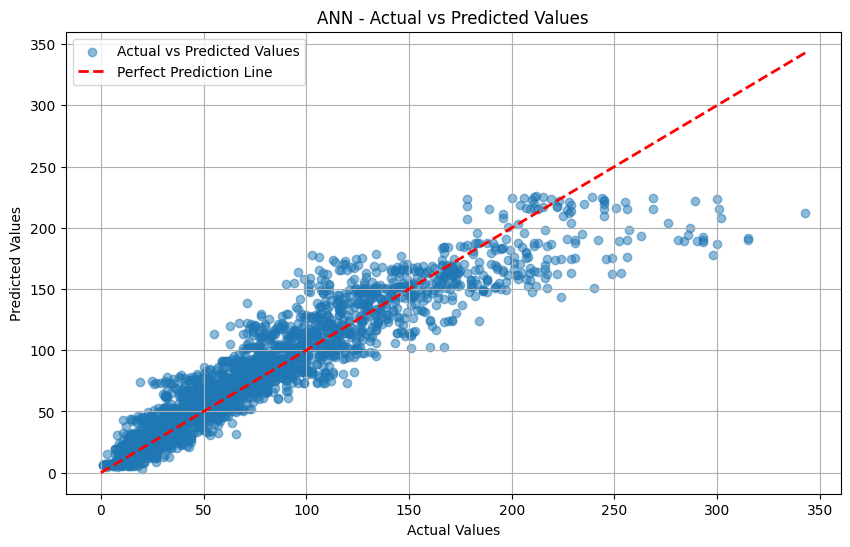

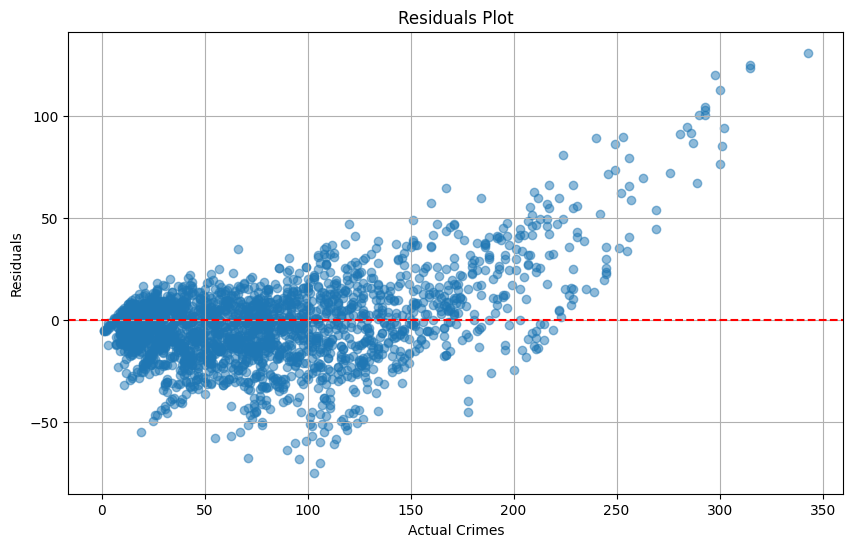

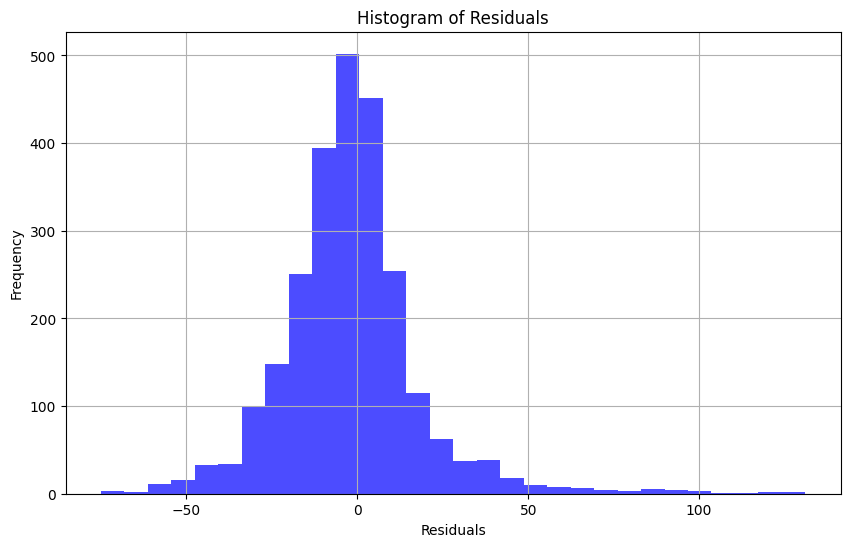

In [9]:
import pandas as pd
import numpy as np
import os
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

# Set random seeds for reproducibility
random.seed(73)
np.random.seed(73)
tf.random.set_seed(73)

# Ensure TensorFlow uses deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Load your data
data = pd.read_csv('C:\\Users\\luigi\\Desktop\\Third Year\\Thesis\\Artefact\\Data\\train_set.csv', header=0)
data.columns = ['Area', 'Year', 'Month', 'Crime_Category', 'Total_Crimes']

# Drop the 'Year' column since it's not used
data.drop('Year', axis=1, inplace=True)

# Preprocess the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Month', 'Area', 'Crime_Category', 'Total_Crimes']])
scaled_df = pd.DataFrame(scaled_data, columns=['Month', 'Area', 'Crime_Category', 'Total_Crimes'])

# Sorting data in a stable manner to prevent any randomness due to equivalent sorting keys
scaled_df.sort_values(by=['Month', 'Crime_Category', 'Area'], inplace=True, kind='mergesort')

# Save the scaler to a file for later use
directory = r'C:\Users\luigi\Desktop\Third Year\Thesis\Artefact\Scripts\ANN'
if not os.path.exists(directory):
    os.makedirs(directory)
scaler_path = os.path.join(directory, 'scaler.gz')
joblib.dump(scaler, scaler_path)

# Prepare the input and output for the ANN
X = scaled_df[['Month', 'Area', 'Crime_Category']]
y = scaled_df['Total_Crimes']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# Define and compile the ANN model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', optimizer=optimizer)

# Fit the model with validation data
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Save the trained model to a file
model_path = os.path.join(directory, 'ann_model.h5')
model.save(model_path)

# Load the test set and preprocess it similar to the training set
test_data = pd.read_csv('C:\\Users\\luigi\\Desktop\\Third Year\\Thesis\\Artefact\\Data\\test_set.csv', header=0)
test_data.columns = ['Area', 'Year', 'Month', 'Crime_Category', 'Total_Crimes']
test_data.drop('Year', axis=1, inplace=True)
test_data = test_data.apply(pd.to_numeric, errors='coerce')
test_data.dropna(inplace=True)

# Load the scaler and transform the test data
scaler = joblib.load(scaler_path)
test_scaled = scaler.transform(test_data[['Month', 'Area', 'Crime_Category', 'Total_Crimes']])
test_X = pd.DataFrame(test_scaled, columns=['Month', 'Area', 'Crime_Category', 'Total_Crimes'])[['Month', 'Area', 'Crime_Category']]

# Load the trained model and make predictions on the test set
model = load_model(model_path)
test_predictions = model.predict(test_X)

# Inverse transform the predicted values to the original scale
dummy_features = np.zeros((test_predictions.shape[0], test_scaled.shape[1] - 1))
full_test_predictions = np.concatenate([dummy_features, test_predictions], axis=1)
final_predictions = scaler.inverse_transform(full_test_predictions)[:, -1]

# Add the predicted values to the test data
test_data['Predicted_Crimes'] = final_predictions
print(test_data[['Total_Crimes', 'Predicted_Crimes']])

# Save the predictions as a CSV
test_data.to_csv('C:\\Users\\luigi\\Desktop\\Third Year\\Thesis\\Artefact\\Data\\Model Predictions\\ANN_predictions.csv', index=False)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data['Total_Crimes'], test_data['Predicted_Crimes'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(test_data['Total_Crimes'] - test_data['Predicted_Crimes']))

# Calculate R-squared (R2)
ss_res = np.sum((test_data['Total_Crimes'] - test_data['Predicted_Crimes'])**2)
ss_tot = np.sum((test_data['Total_Crimes'] - np.mean(test_data['Total_Crimes']))**2)
r2 = 1 - (ss_res / ss_tot)

# Calculate Pearson correlation coefficient (R)
corr_coef = np.corrcoef(test_data['Total_Crimes'], test_data['Predicted_Crimes'])[0, 1]

# Print error metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)
print("Pearson correlation coefficient (R):", corr_coef)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'], color='green', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the actual vs predicted crimes
plt.figure(figsize=(10, 6))
plt.scatter(test_data['Total_Crimes'], test_data['Predicted_Crimes'], alpha=0.5, label='Actual vs Predicted Values')

# Generate a diagonal line (y=x) for perfect predictions
max_val = max(test_data['Total_Crimes'].max(), test_data['Predicted_Crimes'].max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction Line')

plt.title('ANN - Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Calculate residuals
residuals = test_data['Total_Crimes'] - test_data['Predicted_Crimes']

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(test_data['Total_Crimes'], residuals, alpha=0.5)
plt.title('Residuals Plot')
plt.xlabel('Actual Crimes')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Histogram of the residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

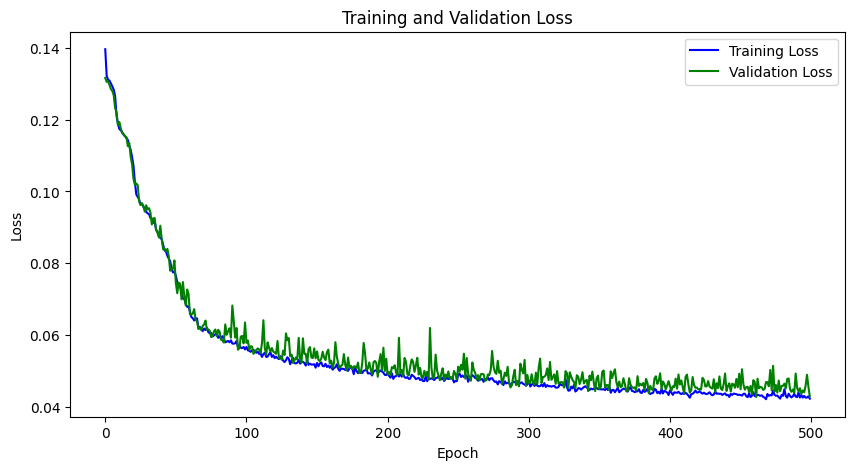

In [11]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'], color='green', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()